# Import libarary

In [33]:
import sys
import os
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings 
warnings.filterwarnings("ignore")

#### Set up for display max width

In [34]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None) 

# Import dataset

In [35]:
## Read data
df = pd.read_excel("../data/Cheese_short.xlsx", sheet_name="Sheet1")
df.head(2)

,ID_judge,Product,Hedonic_category,FreeJAR_description
0,33002,CE,I like it a lot,The taste is nice.
1,33002,M,I like it moderately,"It's good, but the flavor is a bit overpowering."


# Load model Zero-shot NLI 

## If you don't have model, you use directly my model on this folder

In [36]:
# Load the tokenizer and model from the checkpoint
model_path = "../model/fine_tuned_deberta_nli 018"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, ignore_mismatched_sizes=True)
print(model.config.id2label)

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

{0: 'entailment', 1: 'neutral', 2: 'contradiction'}


##### Some model using class 0 is entailment and 2 is contradiction, you should focus this infomation

### Or you can load my model from Huggingface

In [ ]:
model_path = "Phucle103198/PARRA"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
print(model.config.id2label)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


## Or if you want to try another model, you can download via Huggingface

In [37]:
''' Rename model name from Huggingface and run this code
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
'''

' Rename model name from Huggingface and run this code\nmodel_name = "MoritzLaurer/DeBERTa-v3-base-mnli"\ntokenizer = AutoTokenizer.from_pretrained(model_name)\nmodel = AutoModelForSequenceClassification.from_pretrained(model_name)\n'

# Start with STEP 1: Prediction

In [38]:
hedonic_labels =  ["I don't like it", 'I like it moderately', 'I like it a lot']
hypotheses1 = [f"The consumer of this product said {label}." for label in hedonic_labels]
results1 = []
for i in df['FreeJAR_description'].tolist():
    premise = i
    ## premise-hypothesis
    pairs1 = [(premise, hypothesis) for hypothesis in hypotheses1]
    ## Token
    inputs1 = tokenizer(pairs1, padding=True, truncation=True, return_tensors="pt").to(device)
    # Run model to get logits
    with torch.no_grad():
        outputs1 = model(**inputs1)
        logits1 = outputs1.logits
    entailment_probs1 = torch.softmax(logits1, dim=0)[:,0]
    results1.append(entailment_probs1)
df_probs = pd.DataFrame([t.tolist() for t in results1], columns=hedonic_labels)
res = pd.concat([df, df_probs], axis=1)

# Next to STEP 2: Comparison

### Post-processing Predicted Results

To better analyze the model's outputs, we will perform some post-processing steps:

#### 1. Extract the Predicted Label
For each row, we will select the label with the highest predicted probability and assign it to a new column called **"Predict"**.

#### 2. Evaluate Consistency
We will compare the predicted label with the label chosen by the consumer:
- If they match, we consider it **"consistent"**.
- If they differ, we label it as **"inconsistent"**.

In [39]:
res['predict'] = res.iloc[:,-3:].idxmax(axis=1)
res['consistency'] = res.apply(lambda row: 'consistent' if row['Hedonic_category'] == row['predict'] else 'inconsistent', axis=1)

### Model Mistake Evaluation
Basically, when the model's prediction does not match the selected label, we consider it a mistake from the model's perspective. In this context, we define two levels of mistakes:
#### 1. Serious Mistake
This occurs when the model predicts something completely opposite to the actual label — for example, predicting **"I don't like it"** when the true label is **"I like it a lot"**, or vice versa. This indicates a major misjudgment by the model.
#### 2. Non-Serious Mistake
This happens when the model's prediction is only slightly off — for example, predicting **"I like it moderately"** instead of **"I like it a lot"**.

---

### Formal Definition
Consider the labels as ordered categories:
- `0` → "I don't like it"  
- `1` → "I like it moderately"  
- `2` → "I like it a lot"

We define mistake severity based on the **distance between the predicted label index and the true label index**:
- If the difference is `2`: **Serious mistake**
- If the difference is `1`: **Nonserious mistake**
- If the difference is `0`: ✅ **Correct prediction**

In [40]:
res["mistake"] = res['Hedonic_category'] != res['predict']
res["serious_mistake"] = ((res['Hedonic_category'] == "I don't like it") & (res['predict'] == "I like it a lot")) | ((res['Hedonic_category'] == "I like it a lot") & (res['predict'] == "I don't like it"))
res["nonserious_mistake"] = ((res['Hedonic_category'] == "I like it moderately") & ((res['predict'] == "I like it a lot") | (res['predict'] == "I don't like it")))

### Now we have dataframe look like

In [41]:
res.head()

,ID_judge,Product,Hedonic_category,FreeJAR_description,I don't like it,I like it moderately,I like it a lot,predict,consistency,mistake,serious_mistake,nonserious_mistake
0,33002,CE,I like it a lot,The taste is nice.,0.047357,0.451463,0.501180,I like it a lot,consistent,False,False,False
1,33002,M,I like it moderately,"It's good, but the flavor is a bit overpowering.",0.246188,0.502695,0.251118,I like it moderately,consistent,False,False,False
2,33002,B,I like it moderately,"It's good, but the flavor is a little strong.",0.183099,0.488982,0.327920,I like it moderately,consistent,False,False,False
3,33002,R,I like it moderately,"It's good, but the texture is a tad too soft.",0.220993,0.445555,0.333452,I like it moderately,consistent,False,False,False
4,33002,C,I like it a lot,"The taste is good, but the texture is a bit odd.",0.213881,0.530381,0.255738,I like it moderately,inconsistent,True,False,False


# Assess consistency of the data
## Global consistency

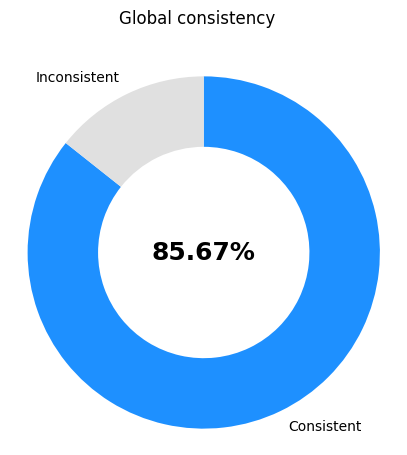

In [42]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
consistent_value = res['consistency'].value_counts()['consistent']*100/len(res)
sizes = [consistent_value, 100-consistent_value]
colors = ['#1E90FF', '#E0E0E0']  # màu chính và màu nền
labels = ['Consistent', 'Inconsistent']
ax.pie(sizes, labels=labels, colors=colors, startangle=90, counterclock=False, wedgeprops={'width': 0.4}) 
ax.text(0, 0, '{}%'.format(round(consistent_value,2)), ha='center', va='center', fontsize=18, weight='bold')
fig.suptitle("Global consistency")
plt.axis('equal')  # make sure that circle
plt.show()

##### Global consistency: a crucial metric that reflects how coherent and interpretable a comment is from the model’s perspective. It serves as an overall consistency index, capturing the unified meaning of the entire comment.

## Class-level consistency

#### Confusion matrix

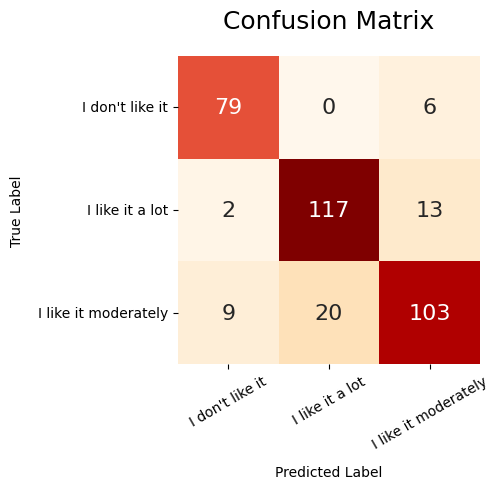

In [43]:
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(hedonic_labels) ### Make sure that x-axis and y-axis have same order like Hedonic labels
categories_encoded = label_encoder.transform(res['Hedonic_category'])
original_classes = list(label_encoder.classes_)

swapped_classes = [original_classes[0], original_classes[2], original_classes[1]]
# Create confusion matrix
cm = confusion_matrix(res['Hedonic_category'], res['predict'], labels=swapped_classes)
# Create a more visually appealing plot
plt.figure(figsize=(5,5))
sns.heatmap(cm, 
            annot=True, 
            fmt='d',
            cmap='OrRd',
            xticklabels=swapped_classes,
            yticklabels=swapped_classes, cbar=False,
            annot_kws={"size": 16})
plt.title('Confusion Matrix', pad=20, fontsize=18)
plt.xlabel('Predicted Label', labelpad=10, fontsize=10)
plt.ylabel('True Label', labelpad=10, fontsize=10)
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Plot consistency per each class

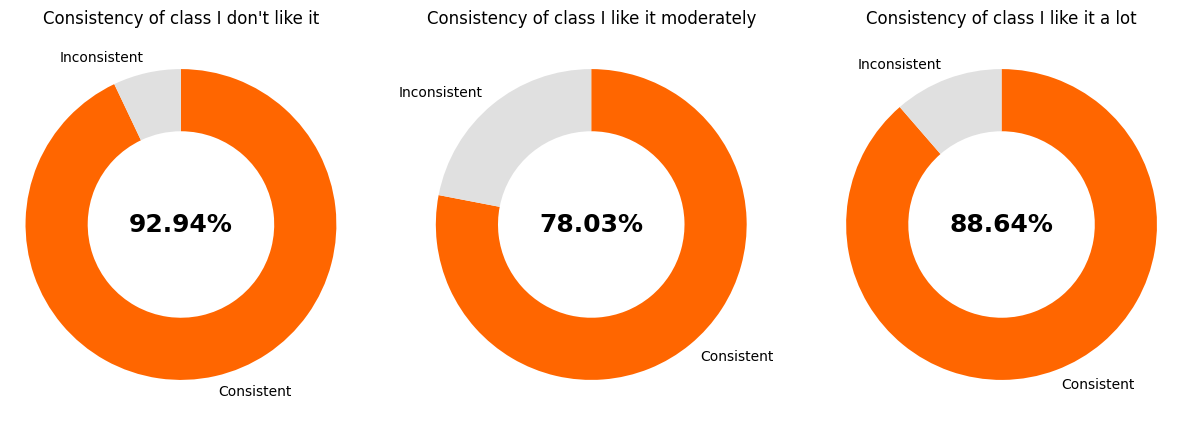

In [44]:
colors = ['#FF6600', '#E0E0E0']  # change color in here
labels = ['Consistent', 'Inconsistent']
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
## I don't like it
res_temp = res[res['Hedonic_category'] == "I don't like it"]
consistent_value = res_temp['consistency'].value_counts()['consistent']*100/len(res_temp)
sizes = [consistent_value, 100-consistent_value]
axs[0].pie(sizes, labels=labels, colors=colors, startangle=90, counterclock=False, wedgeprops={'width': 0.4}) 
axs[0].text(0, 0, '{}%'.format(round(consistent_value,2)), ha='center', va='center', fontsize=18, weight='bold')
axs[0].set_title("Consistency of class I don't like it")
axs[0].axis('equal')  # make sure the circle is not distorted
## I like it moderately
res_temp = res[res['Hedonic_category'] == "I like it moderately"]
consistent_value = res_temp['consistency'].value_counts()['consistent']*100/len(res_temp)
sizes = [consistent_value, 100-consistent_value]
axs[1].pie(sizes, labels=labels, colors=colors, startangle=90, counterclock=False, wedgeprops={'width': 0.4}) 
axs[1].text(0, 0, '{}%'.format(round(consistent_value,2)), ha='center', va='center', fontsize=18, weight='bold')
axs[1].set_title("Consistency of class I like it moderately")
axs[1].axis('equal')  # make sure the circle is not distorted
## I like it a lot
res_temp = res[res['Hedonic_category'] == "I like it a lot"]
consistent_value = res_temp['consistency'].value_counts()['consistent']*100/len(res_temp)
sizes = [consistent_value, 100-consistent_value]
axs[2].pie(sizes, labels=labels, colors=colors, startangle=90, counterclock=False, wedgeprops={'width': 0.4}) 
axs[2].text(0, 0, '{}%'.format(round(consistent_value,2)), ha='center', va='center', fontsize=18, weight='bold')
axs[2].set_title("Consistency of class I like it a lot")
axs[2].axis('equal')  # make sure the circle is not distorted
plt.show()

#### This analysis examines the consistency of predictions within each hedonic category, providing insight into how distinctly consumers express their preferences in text.
#### Notably, the category "I like it moderately" shows lower consistency, likely due to the inherently ambiguous nature of moderate liking. Such comments often contain mixed sentiments, which makes it more challenging for semantic models to align with a clear emotional signal.


## Judge-level consistency

In [45]:
res.head(2)

,ID_judge,Product,Hedonic_category,FreeJAR_description,I don't like it,I like it moderately,I like it a lot,predict,consistency,mistake,serious_mistake,nonserious_mistake
0,33002,CE,I like it a lot,The taste is nice.,0.047357,0.451463,0.501180,I like it a lot,consistent,False,False,False
1,33002,M,I like it moderately,"It's good, but the flavor is a bit overpowering.",0.246188,0.502695,0.251118,I like it moderately,consistent,False,False,False


In [46]:
mistake_summary = res.groupby('ID_judge')[['mistake', 'serious_mistake']].sum().reset_index()
serious_mistake_count = mistake_summary.groupby('mistake')['serious_mistake'].sum().reindex(range(0, mistake_summary['mistake'].max() + 1), fill_value=0)
mistake_count = mistake_summary['mistake'].value_counts().reindex(range(0, mistake_summary['mistake'].max() + 1), fill_value=0)
nonserious_mistake_count = mistake_count - serious_mistake_count

#### In this case, we set the threshold is 4, which is half of the number of product

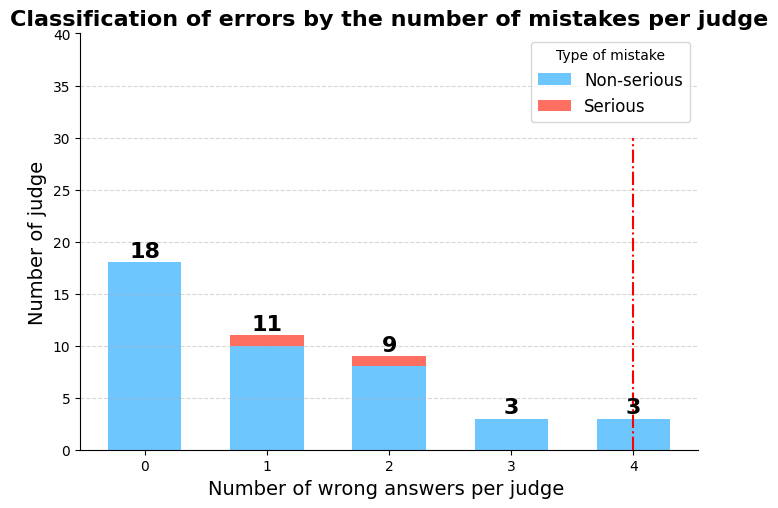

In [47]:
wrong_predict = np.array(mistake_count.index)
weight_counts = {
    "Non-serious": np.array(nonserious_mistake_count),
    "Serious": np.array(serious_mistake_count),
}
colors = {
    "Non-serious": "#6EC6FF",        
    "Serious": "#FF6F61",  
}
width = 0.6
fig, ax = plt.subplots(figsize=(7, 5))
# stacking
bottom = np.zeros(len(wrong_predict))
for label, weight_count in weight_counts.items():
    ax.bar(wrong_predict, weight_count, width, label=label, bottom=bottom, color=colors[label])
    bottom += weight_count
ax.vlines(x=4, ymin=0, ymax=30, linestyles="dashdot", colors="red") 
ax.set_xlabel("Number of wrong answers per judge ", fontsize=14)
ax.set_ylabel("Number of judge", fontsize=14)
ax.legend(title="Type of mistake", fontsize=12)
ax.set_xticks(wrong_predict)
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.set_ylim(0,40)
for i, v in enumerate(mistake_count):
    ax.text(i, v + 0.5, str(v), ha='center', fontsize=16, fontweight='bold')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.title("Classification of errors by the number of mistakes per judge", fontsize=16, fontweight='bold')
plt.show()


### Detail of 2 serious mistake

In [48]:
res[res['serious_mistake'] == True][['Hedonic_category', 'FreeJAR_description']]

,Hedonic_category,FreeJAR_description
174,I like it a lot,"The texture is good because it's firm. It looks good too. The taste is quite pronounced, maybe a little too strong for my liking."
277,I like it a lot,This product is good because the taste is very good; what I didn't like was the texture.


##### In both cases, the judge selected "I like it a lot", yet their written descriptions suggest otherwise. Interestingly, while the model strongly predicts "I don't like the product", this also seems inconsistent with the sentences. A more appropriate classification might be "I like it moderately", which better reflects the nuanced tone of the feedback.

### Who Makes More Mistakes?

In [49]:
mistake_summary[mistake_summary['mistake']>=4]

,ID_judge,mistake,serious_mistake
1,33003,4,0
8,33011,4,0
30,33065,4,0


In [50]:
res[(res['ID_judge'].isin([33003, 33011, 33065])) & (res['consistency'] == 'inconsistent')][['Hedonic_category', 'FreeJAR_description', 'predict']]

,Hedonic_category,FreeJAR_description,predict
8,I like it moderately,"This is good because it's got a soft, melt-in-your-mouth texture. It feels nice when you eat it, and even though it has a slightly artificial blue cheese taste, I like it.",I like it a lot
9,I like it moderately,This is good because it's very soft and just melts in your mouth. It's got a sweet and fruity flavor.,I like it a lot
14,I like it moderately,"This is good because it has a noticeable strength in your mouth, a firm texture, yet it still melts nicely.",I like it a lot
15,I like it moderately,"This is good because it's a little stronger than C, maybe it has more cow's milk.",I like it a lot
64,I like it a lot,"It's good, but it could be firmer.",I like it moderately
67,I like it moderately,"It doesn't have enough taste, and the texture isn't good.",I don't like it
69,I like it moderately,It doesn't have enough taste.,I don't like it
71,I like it moderately,The texture isn't good; it seems buttery.,I don't like it
238,I like it moderately,This is good because it has a good taste.,I like it a lot
242,I don't like it,It doesn't have enough flavor.,I like it moderately


## Judge-Product level Consistency

### Consistency Analysis: Panelists and Products

Inspired by the *panel performance* functionality in the **SensomineR** package, we adopt a similar approach to assess how consistently individual testers (panelists) evaluate products, note that from the perspective of a predictive model.

In this analysis, we take a slightly different approach compared to the previous section.

Instead of using the **highest predicted label** (i.e., the label with the highest probability), we focus on the **model's confidence in the label actually selected by the tester**.

That is, for each prediction, we extract the probability assigned by the model to the label that the human tester chose — regardless of whether it was the top prediction or not.

#### Objectives of This Analysis

- **Identify Consistent vs. Inconsistent Testers**  
  We aim to evaluate the level of agreement between the model's predictions and each tester's selected label. This allows us to identify:
  - **Consistent individuals**, whose responses align well with the model.
  - **Inconsistent individuals**, whose evaluations frequently differ from the model’s predictions.

- **Assess Product-Level Consistency**  
  We also apply this analysis at the product level. Specifically, we examine:
  - Which products tend to yield **high agreement** between model predictions and tester labels (i.e., easier to evaluate consistently).
  - Which products result in **high disagreement**, indicating that they may be more subjective or polarizing among testers.

This two-layered analysis helps us understand not only the reliability of individual testers, but also which products provoke more diverse or inconsistent evaluations—insightful for both product development and panel management.


In [51]:
def get_prob_chosen(row):
    return row[f"{row['Hedonic_category']}"]
res["prob_chosen"] = res.apply(get_prob_chosen, axis=1)

In [52]:
pivot = res.groupby(["ID_judge", "Product"])["prob_chosen"].mean().unstack()
pivot["Median"] = pivot.median(axis=1)
median_row = pivot.median(axis=0)
median_row.name = "Median"
pivot_with_median = pd.concat([pivot, median_row.to_frame().T])
sorted_cols = pivot_with_median.loc["Median"].sort_values(ascending=False).index
sorted_rows = pivot_with_median["Median"].sort_values(ascending=False).index
sorted_df = pivot_with_median.loc[sorted_rows, sorted_cols]

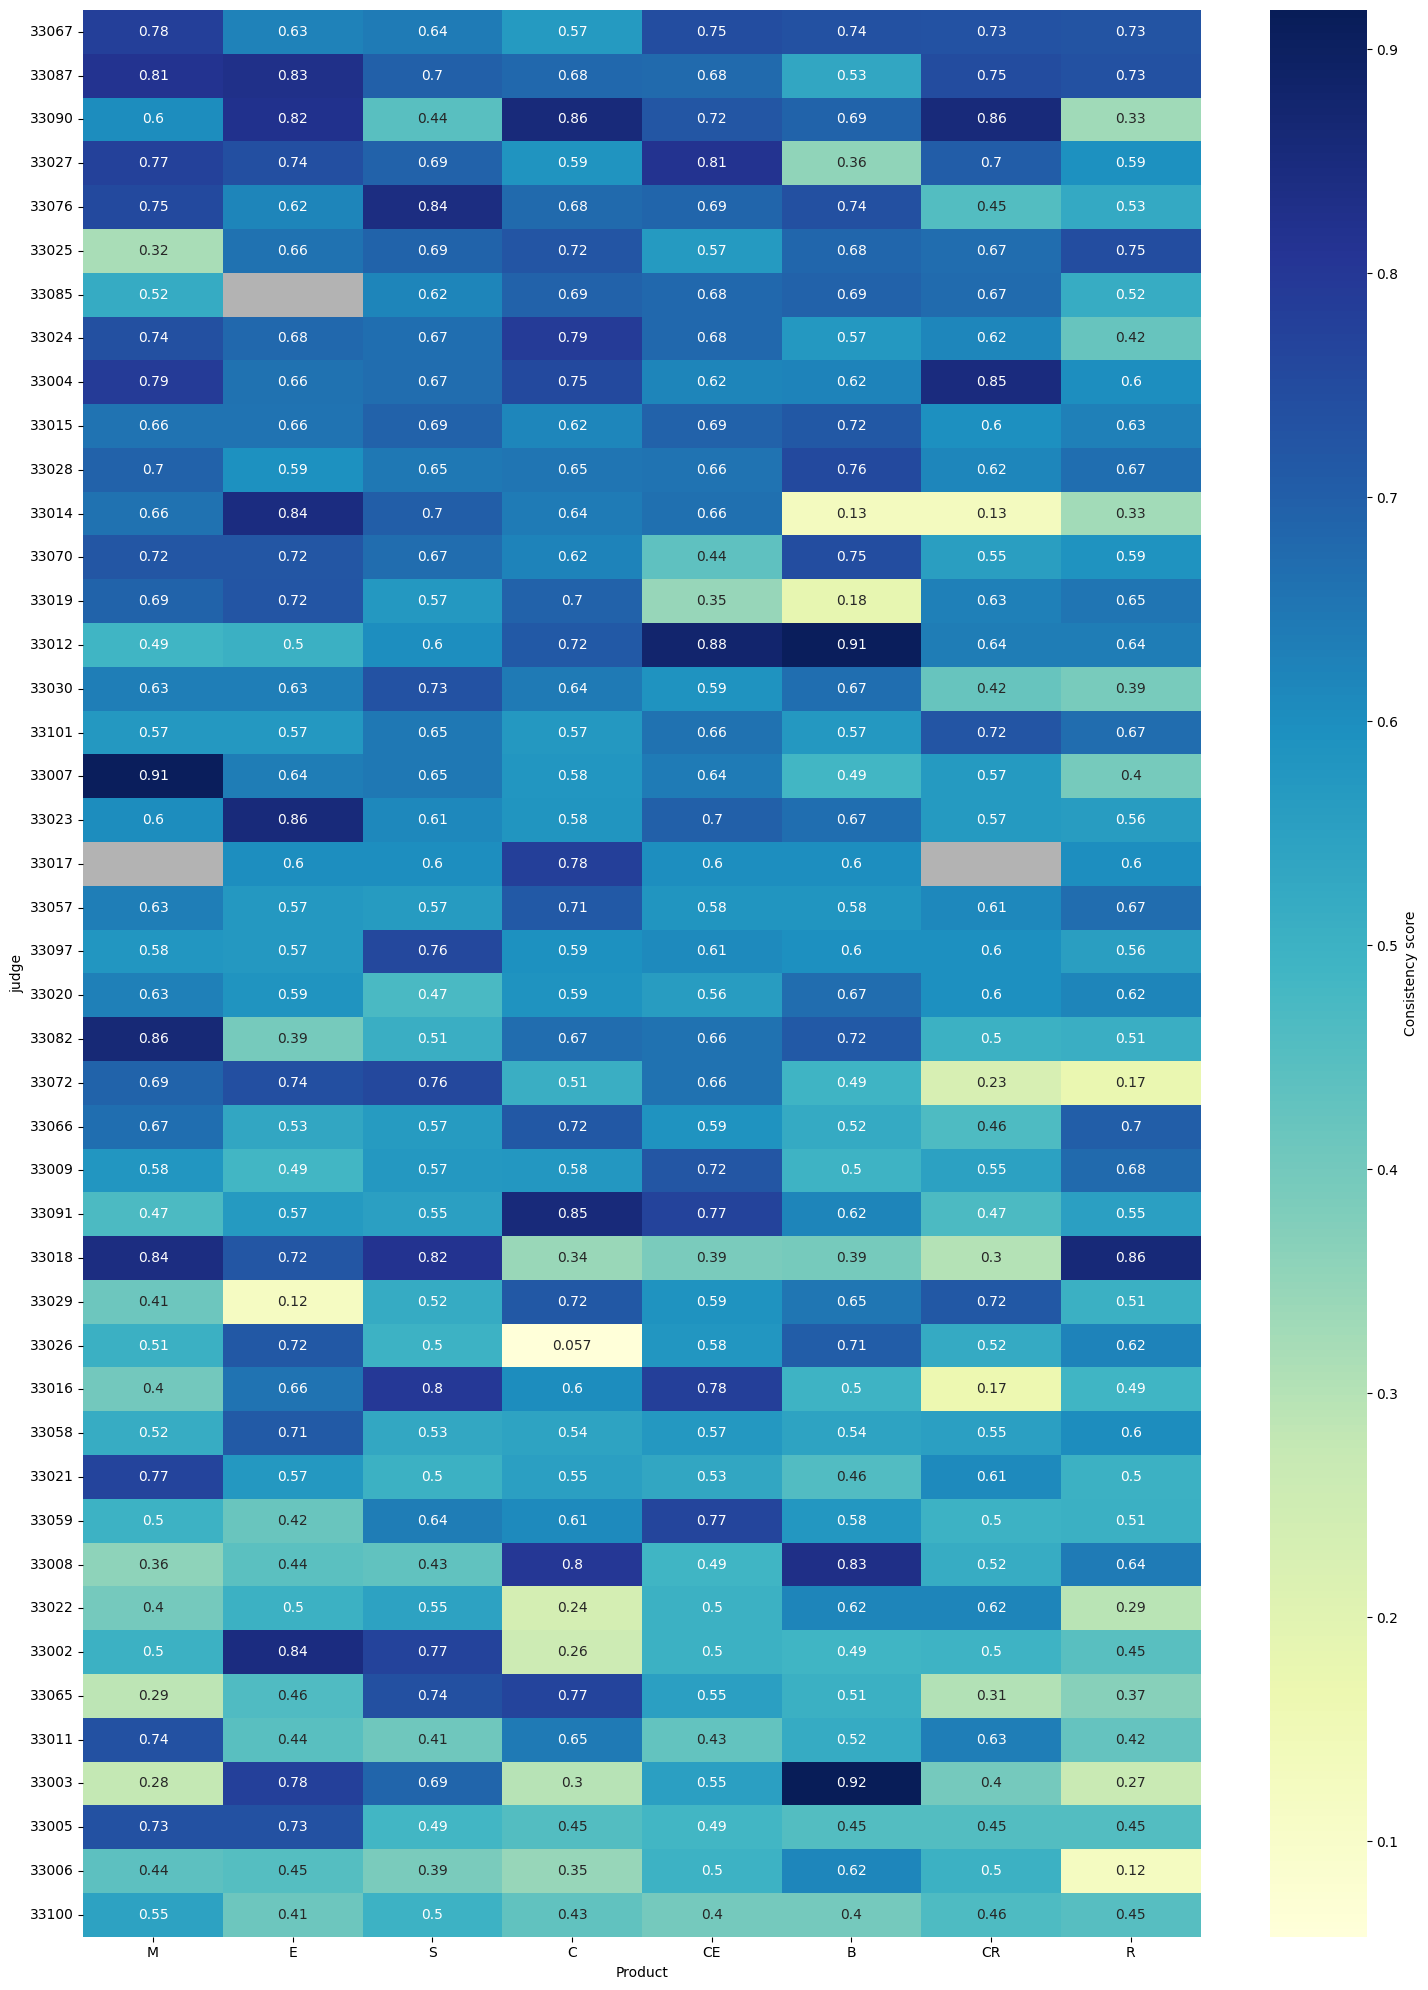

In [53]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,20))
ax = sns.heatmap(sorted_df.drop(columns="Median", index="Median"), annot=True, cmap="YlGnBu", cbar_kws={'label': 'Consistency score'}, )
ax.collections[0].cmap.set_bad('0.7')
plt.xlabel("Product")
plt.ylabel("judge")
plt.tight_layout()
plt.show()


#### - From the product perspective, it is evident that products M and E demonstrate higher consistency in the results compared to CR and R. This suggests that M and E may be easier for testers to evaluate reliably, possibly due to clearer sensory characteristics or more distinct differences. In contrast, CR and R might have subtle or ambiguous attributes that lead to more variability in responses.

#### - From the Judge perspective, individuals 33067, 33087, and 33090 exhibit a higher degree of consistency in their evaluations, whereas testers 33100, 33006, and 33005 show more variation in their responses. This inconsistency could be attributed to factors such as lack of concentration, fatigue, or unclear understanding of the test protocol, all of which may affect their ability to evaluate the products consistently.

